<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/Elisa/NN_transferlearning_V00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
drive.mount('/content/Drive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import os
import copy
import glob
import time
from pathlib import Path

import PIL
from PIL import Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [47]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  3 17:09:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |   4507MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [49]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [50]:
#Paramter des Netzes
NUM_ClASSES = 2
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 5
BATCH_SIZE = 12

In [51]:
#Daten laden
import zipfile
with zipfile.ZipFile('/content/Drive/MyDrive/HA_NN/dogs-vs-cats.zip') as entire_zip:
     entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
     train_zip.extractall('.')

train_dir = './train'

In [52]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [53]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [54]:
class Dogs_CatsDataset(Dataset):

    def __init__(self, root, image_dir, csv_file, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])  
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [55]:
Img_dir = glob.glob(os.path.join(train_dir, '*.jpg'))
x_train ,x_test = train_test_split(Img_dir,test_size=0.2,random_state=42)

In [56]:
image_dir = '/content/Drive/MyDrive/HA_NN/dogs-vs-cats/train/'
csv_file = '/content/Drive/MyDrive/HA_NN/dogs-vs-cats/train/dogs_cats.csv'

transform_test = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

transform_Val = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

#new
x_train ,x_test = train_test_split(Img_dir,test_size=0.2)   #Image Split: Teilen 

train_dataset  = DogVsCatDataset(x_train, transform= transform_test)
validation_dataset = DogVsCatDataset(x_test, transform= transform_Val)

print('Anzahl Daten: ',len(Img_dir))
print('Anzahl Train_Daten: ',len(train_dataset))
print('Anzahl Test_Daten: ',len(validation_dataset))

Anzahl Daten:  25000
Anzahl Train_Daten:  20000
Anzahl Test_Daten:  5000


In [57]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Anzahl train_loader: ',len(train_loader))
print('Anzahl test_loader: ',len(validation_loader))

Anzahl train_loader:  1667
Anzahl test_loader:  417


In [58]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([12, 3, 224, 224])
Image label dimensions: torch.Size([12])
Image batch dimensions: torch.Size([12, 3, 224, 224])
Image label dimensions: torch.Size([12])


In [59]:
classes = ('Cat', 'Dog')

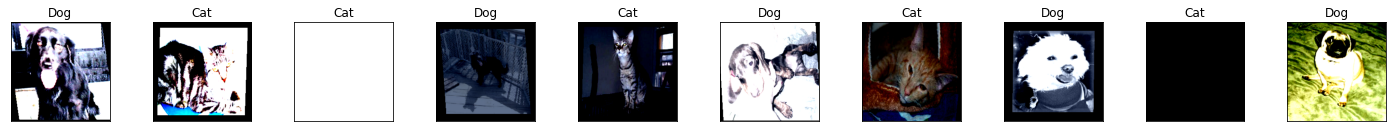

In [60]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [61]:
#Loading pretrained model
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [62]:
for param in model.features.parameters():
  param.requires_grad = False

In [63]:
model.classifier[6] = nn.Sequential(nn.Linear(4096, NUM_ClASSES))
model_CNN=model.to(device)
print(model_CNN)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [64]:
from torchsummary import summary
summary (model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [65]:
#Loss
criterion = nn. CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [66]:
def train_val(epoch, train_loss_history,train_corrects_history,val_loss_history,val_corrects_history):
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0


    since = time.time()
    best_acc = 0.0
    
    best_model_wts = copy.deepcopy(model_CNN.state_dict())
    # Set model to training mode
    model_CNN.train()
        
    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # Forward Propagation
        y_predicted = model_CNN(X_train)
      
        # Zero gradient buffers
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        _, preds = torch.max(y_predicted, 1)
        train_loss += loss.item()
        train_corrects += torch.sum(preds == y_train.data)
        
    else:
        # no need to build the computation graph for backprop when computing accuracy
        with torch.no_grad():
          for  X_val, y_val in validation_loader:
           

            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model_CNN(X_val)

            val_loss = criterion(val_outputs, y_val)

            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == y_val.data)

        epoch_loss = train_loss/len(train_loader.dataset)
        epoch_acc = train_corrects.float()/ len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_corrects_history.append(epoch_acc)

        val_epoch_loss = val_loss/len(validation_loader.dataset)
        val_epoch_acc = val_corrects.float()/ len(validation_loader.dataset)

###############################
        if val_epoch_acc > best_acc:
          best_acc = val_epoch_acc
          best_model_wts = copy.deepcopy(model_CNN.state_dict())

##############################

        val_loss_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item())) 

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model_CNN.load_state_dict(best_model_wts)

In [67]:
train_loss_history = []
train_corrects_history = []
val_loss_history = []
val_corrects_history = []
for epoch in range(NUM_EPOCHS):
    train_val(epoch,train_loss_history,train_corrects_history,val_loss_history,val_corrects_history)

epoch : 1
training loss: 0.0153, acc 0.9211 
validation loss: 0.0000, validation acc 0.9858 
Training complete in 4m 39s
Best val Acc: 0.985800
epoch : 2
training loss: 0.0125, acc 0.9323 
validation loss: 0.0000, validation acc 0.9838 
Training complete in 4m 38s
Best val Acc: 0.983800
epoch : 3
training loss: 0.0121, acc 0.9333 
validation loss: 0.0001, validation acc 0.9874 
Training complete in 4m 39s
Best val Acc: 0.987400
epoch : 4
training loss: 0.0114, acc 0.9388 
validation loss: 0.0000, validation acc 0.9868 
Training complete in 4m 39s
Best val Acc: 0.986800
epoch : 5
training loss: 0.0110, acc 0.9416 
validation loss: 0.0000, validation acc 0.9896 
Training complete in 4m 38s
Best val Acc: 0.989600


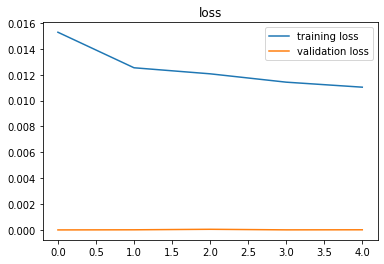

In [68]:
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.title('loss')
plt.savefig('/content/Drive/MyDrive/HA_NN/Loss_V00.png')

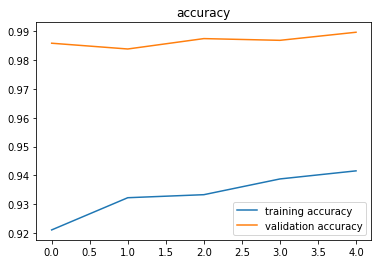

In [69]:
plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()
plt.title('accuracy')
plt.savefig('/content/Drive/MyDrive/HA_NN/Accuracy_V00.png')

In [70]:
from sklearn.metrics import confusion_matrix
#for i in range(len(validation_loader)-1):
x_test,y_test = next(iter(validation_loader))
y_pred = model_CNN(x_test.to(device))
y_test = y_test.to('cpu')
y=y_pred.data.max(1)[1].to('cpu')
Conf_Mat = confusion_matrix(y,y_test)
#print("Confusion Matrix : ")

for i in range(len(validation_loader)-1):
    x_test,y_test = next(iter(validation_loader))
    y_pred = model_CNN(x_test.to(device))
    y_test = y_test.to('cpu')
    y=y_pred.data.max(1)[1].to('cpu')
    Conf_Mat += confusion_matrix(y,y_test)
#print("Confusion Matrix : ")

Conf_Mat

array([[4170,    0],
       [   0,  834]])

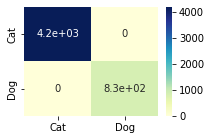

In [71]:
import seaborn as sn
df_cm = pd.DataFrame(Conf_Mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='.2%')
plt.savefig('/content/Drive/MyDrive/HA_NN/ConfMat_V00.png')

In [72]:
model_save_name = 'CNN_catdog.pt'
path = F"/content/Drive/MyDrive/Hausarbeit NN/{model_save_name}" 
torch.save(model_CNN.state_dict(), path)

In [73]:
model_CNN_2 = torch.load(path)
model_CNN_2

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3